# Kaggle: Histopathologic Cancer Detection

see: https://www.kaggle.com/c/histopathologic-cancer-detection  

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

* Evaluation: submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## 1. Data Preprocess

此資料集為病理切片，其中部分切片是含有腫瘤的，有22萬片有標記的Trainset，其中有腫瘤和沒腫瘤的切片數大概4:6，我們的任務是去預測哪一些是有腫瘤的切片。  
每個切片大小都是96 x 96 px，如果此切片被標注為「有腫瘤」，則代表在中心32 x 32 px至少有一個pixel含有腫瘤。

In [1]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [2]:
import os
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.utils import Sequence
from tensorflow.python.keras import layers as L
from tensorflow.python.keras import optimizers as O
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
from imgaug import augmenters as iaa

ORIGINAL_SIZE = 96
CROP_SIZE = 64
BATCH_SIZE = 8
DATA_ROOT = '/notebooks/nbs/data/histopathologic-cancer-detection/'
CHECKPOINT_PATH = 'checkpoint.ckpt'

In [3]:
class SectionSequence(Sequence):
    def __init__(self, image_dir, batch_size, label_csv=None,
                    do_normalization=True, do_augment=False, crop_size=CROP_SIZE,
                    resize_factor=1, transformation=None):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.label_data = None
        if label_csv is not None:
            self.label_data = pd.read_csv(label_csv)

        self.do_normalization = do_normalization      
        self.do_augment = do_augment
        self.crop_size = crop_size
        self.resize_factor = resize_factor
        self.transformation = transformation

    def __len__(self):
        return self.label_data.shape[0] // self.batch_size

    def __getitem__(self, batch_idx):
        img_list = []
        label_list = []

        for idx in range(batch_idx * self.batch_size, (batch_idx + 1) * self.batch_size, 1):
            img_name = os.path.join(self.image_dir, str(self.label_data['id'].iloc[idx])+'.tif')
            img = Image.open(img_name)
            img = np.array(img, dtype=np.float32)
            
            if self.do_augment:
                rotate_tol = 45
                translate_px_tol = 10
                
                sometimes_05 = lambda aug: iaa.Sometimes(0.5, aug)
                sometimes_03 = lambda aug: iaa.Sometimes(0.3, aug)
                seq = iaa.Sequential([
                    iaa.Fliplr(0.3), # horizontal flips
                    iaa.Flipud(0.3), # vertical flips
                    
                    sometimes_03(
                        iaa.Affine(
                            translate_px={
                                'x': (-translate_px_tol, translate_px_tol),
                                'y': (-translate_px_tol, translate_px_tol)
                            },
                            rotate=(-rotate_tol, rotate_tol),
                        )
                    ), 
#                     sometimes_03(
#                         iaa.ContrastNormalization((0.9, 1.1)),  # random contrast
#                     ),
#                     sometimes_03(
#                         iaa.Multiply((0.9, 1.1), per_channel=0.2),  # random brightness
#                     )
#                     iaa.Sometimes(0.5,
#                         iaa.GaussianBlur(sigma=(0, 0.5))
#                     ),
#                     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                ], random_order=True) # apply augmenters in random order

                img = seq.augment_image(img)

            if self.crop_size:
                # crop to center
                start_crop = (ORIGINAL_SIZE - self.crop_size) // 2
                end_crop = start_crop + self.crop_size
                img = img[start_crop:end_crop, start_crop:end_crop]
            
            if self.do_normalization:
                img = (img - 127.5) / 127.5 # Normalize the color range to [-1, 1]
                
            if self.resize_factor != 1:
                img = Image.fromarray(img.astype('uint8'), 'RGB')
                width, height = img.size
                new_width, new_height = int(width * self.resize_factor), int(height * self.resize_factor)
                img = img.resize((new_width, new_height), Image.ANTIALIAS)
                img = np.array(img, dtype=np.float32)
                
            if self.transformation is not None:
                img = self.transformation(img)
    
            img_list.append(img)
            if self.label_data is not None:
                label = self.label_data['label'].iloc[idx]
                label_list.append(label)
                
    
        imgs = np.stack(img_list, axis=0)
        
        if self.label_data is not None:
            labels = np.stack(label_list, axis=0)
            return imgs, labels
        else:
            return imgs

In [5]:
def reverse_img(array):
    return (array * 127.5) + 127.5

def plot_from_normalized_array(array):
    return Image.fromarray(reverse_img(array).astype('uint8'), 'RGB')

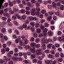

In [6]:
data = SectionSequence(
    image_dir=DATA_ROOT+'train/', batch_size=BATCH_SIZE, label_csv=DATA_ROOT+'train_labels.csv',
    do_augment=True)
imgs, labels = data[0]
plot_from_normalized_array(imgs[4])

In [8]:
imgs[4].shape

(64, 64, 3)

## 2. Model Training

In [10]:
class SplitDatasetWrapper(Sequence):
    def __init__(self, dataset, begin, end, do_shuffle=True):
        assert begin < end
        assert begin >= 0
        assert end <= len(dataset)

        self.dataset = dataset
        self.shuffle_list = list(range(begin, end))
        if do_shuffle:
            random.shuffle(self.shuffle_list)

    def __len__(self):
        return len(self.shuffle_list)

    def __getitem__(self, idx):
        return self.dataset[self.shuffle_list[idx]]

    def on_epoch_end(self):
        random.shuffle(self.shuffle_list)

In [11]:
def get_model(input_size, loss):
    net = ResNet50(include_top=False, weights='imagenet',
                   input_shape=(input_size, input_size, 3))
    x = net.output
    gap = L.GlobalAveragePooling2D()(x)

    output_layer = L.Dense(1, activation='sigmoid', name='sigmoid')(gap)

    model = Model(inputs=net.input, outputs=output_layer)
    
    for layer in model.layers[:18]:
        if type(layer) == L.normalization.BatchNormalization:
            continue
        layer.trainable = False

    model.compile(optimizer=O.Adam(lr=2e-5),
                  loss=loss, metrics=['accuracy'])
    
    return model

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

def get_callbacks():
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)

    checkpoint_path = CHECKPOINT_PATH
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                  verbose=1, save_best_only=True)
    return es, cp_callback

In [12]:
dataloader = SectionSequence(image_dir=DATA_ROOT+'train/',
                             batch_size=BATCH_SIZE,
                             label_csv=DATA_ROOT+'train_labels.csv')
n_train_samples = int(len(dataloader) * 0.9)

train_dataloader = SplitDatasetWrapper(dataloader, 0, n_train_samples)
val_dataloader = SplitDatasetWrapper(dataloader, n_train_samples, len(dataloader))

aug_dataloader = SectionSequence(image_dir=DATA_ROOT+'train/',
                                 batch_size=BATCH_SIZE,
                                 label_csv=DATA_ROOT+'train_labels.csv', 
                                 do_augment=True)
train_dataloader_aug = SplitDatasetWrapper(aug_dataloader, 0, n_train_samples)

### No augmentation

In [13]:
model_pure = get_model(CROP_SIZE, loss='binary_crossentropy')

es, cp_callback = get_callbacks()

history_pure = model_pure.fit_generator(
    train_dataloader,
    epochs=100,
    steps_per_epoch=2000,
    callbacks=[es, cp_callback],
    validation_data=val_dataloader,
    verbose=2,
    workers=4,
)
model_pure.load_weights(CHECKPOINT_PATH)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.52348, saving model to checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
2000/2000 - 378s - loss: 0.4985 - acc: 0.7598 - val_loss: 0.5235 - val_acc: 0.8206
Epoch 2/100

Epoch 00002: val_loss improved from 0.52348 to 0.41258, saving model to checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
2000/2000 - 347s - loss: 0.4239 - acc: 0.8076 - val_loss: 0.4126 - val_acc: 0.8544
Epoch 3/100

Epoch 00003: val_loss improved from 0.41258 to 0.33348, saving model to checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
2000/2000 - 347s - loss: 0.3930 - acc: 0.8250 - val_loss: 0.3335 - val_acc: 0.8619
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.33348
2000/2000 - 348s - loss: 0.3772 - acc: 0.8369 - val_loss: 0.3383 - val_acc: 0.8592
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.33348
2000/2000 - 345s - loss: 0.3656 - acc: 0.8421 - val_loss: 0.3656 - val_ac

In [15]:
max(history_pure.history['val_acc'])

0.9152581

* 你會發現最後幾個epoch，明顯train loss已經和validation loss脫鉤，所以有overfitting的情況
* 使用aumentation來避免overfitting

### Doing augmentation

In [17]:
model_aug = get_model(CROP_SIZE, loss='binary_crossentropy')

es, cp_callback = get_callbacks()

history_aug = model_aug.fit_generator(
    train_dataloader_aug,
    epochs=100,
    steps_per_epoch=2000,
    callbacks=[es, cp_callback],
    validation_data=val_dataloader,
    verbose=2,
    workers=4,
)
model_aug.load_weights(CHECKPOINT_PATH)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.44388, saving model to checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
2000/2000 - 413s - loss: 0.4930 - acc: 0.7678 - val_loss: 0.4439 - val_acc: 0.8175
Epoch 2/100

Epoch 00002: val_loss improved from 0.44388 to 0.41552, saving model to checkpoint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
2000/2000 - 364s - loss: 0.4360 - acc: 0.8016 - val_loss: 0.4155 - val_acc: 0.8388
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.41552
2000/2000 - 367s - loss: 0.4023 - acc: 0.8226 - val_loss: 0.4396 - val_acc: 0.8348
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.41552
2000/2000 - 369s - loss: 0.3931 - acc: 0.8259 - val_loss: 0.5159 - val_acc: 0.8263
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.41552
2000/2000 - 368s - loss: 0.3776 - acc: 0.8357 - val_loss: 0.5371 - val_acc: 0.8502
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.41552
2000/2000 - 368s - 

In [19]:
max(history_aug.history['val_acc'])

0.92589056

* augmentation確實減緩了overfitting的情況，train loss和validation loss相當接近
* val_loss和val_acc都比沒加augmentation的情況還好

## 3. Analysis

我們就拿有augmentation的模型做一些基本分析

In [21]:
eval_dataloader = SplitDatasetWrapper(dataloader,
                                      n_train_samples,
                                      len(dataloader),
                                      do_shuffle=False)

all_probs = []
all_labels = []
all_preds = []
for imgs, labels in eval_dataloader:
    probs = model_aug.predict(imgs).flatten()
    all_probs.extend(list(probs))
    all_labels.extend(list(labels))
    all_preds.extend(list((probs >= 0.5).astype('int')))

### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

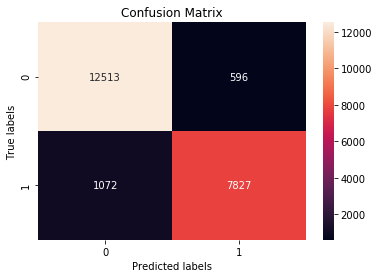

In [22]:
cm = confusion_matrix(all_labels, all_preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d') #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')

In [24]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp= cm[0][1]

acc = (tn + tp) / (tn + fn + tp + fp)
precision = tp / (tp + fp)
recall = tp / (fp + fn)
type_1_err = fp / (fp + fn)
type_2_err = fn / (fp + fn)

print('accuracy = ', acc)
print('precision = ', precision)
print('recall = ', recall)
print('type_1_err : type_2_err = ', type_1_err, ' : ', type_2_err)

accuracy =  0.9242093784078517
precision =  0.9292413629348213
recall =  4.692446043165468
type_1_err : type_2_err =  0.35731414868105515  :  0.6426858513189448


* Type I Error在這個例子代表預測是癌症，但實際上不是
* Type II Error在這個例子代表實際是癌症，但預測不是
* 顯而易見的，Type II Error是我們要極力避免的，但目前的結果顯示卻是相反的。
* 原因是出在在trainset中沒有癌症的數據是比有癌症的數據還多的，所以自然model會偏向預測沒有癌症
* 我們必須想辦法修正這個現象
    * 方法一：model維持不變，但是切threshold時下修，這樣可以使得預測為假的情況(label=0)變少。這種方法是減少(True Negative + False Negative)和增加(False Positive + True Positive)，進而減少Type II Error。
    * 方法二：另外一種做法是，讓model在學習的時候就去加權有腫瘤的sample，讓model在有腫瘤的情況可以學得更好。這種方法是減少False Negative和增加True Positive，進而減少Type II Error，但同時也會間接稀釋掉True Negative和False Positive的分辨度。
    * 兩種方法的面向是不一樣的，孰好孰壞我沒有定論，不過我直覺會覺得有model優化的結果我會比較有信心，所以我會採用第二種方法。

## 4. Model Training - Weighted to avoid Type II Error

* 使用`weighted_binary_crossentropy` 把 `label=1` (有癌症) 的情況加權強調
* 其實這個動作就等效於「增加 `label=1` 的data」
* Weighted Binary Crossentropy (WBC)
    * $WBC(y, \hat{y}) = -(\beta y log\hat{y}+(1-y)log(1-\hat{y}))$
    * To decrease the number of false negatives, set $\beta > 1$. To decrease the number of false positives, set $\beta < 1$.
    * $\beta$ 就是下面的 `pos_weight`
* [YCNote] 其他發現未來可研究的變形binary crossentropy：
    * balanced cross entropy
    * focal loss: tries to down-weight the contribution of easy examples
    * distance to the nearest cell: force the CNN to learn the separation border between touching objects

In [25]:
def create_weighted_binary_crossentropy(pos_weight):
    def convert_to_logits(y_pred):
        # imitate from 
        # https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
        epsilon_ = tf.keras.backend.epsilon()
        output = tf.clip_by_value(y_pred, epsilon_, 1 - epsilon_)
        output = tf.log(output / (1 - output))
        return output

    def weighted_cross_entropy(y_true, y_pred):
        logits = convert_to_logits(y_pred)
        return tf.nn.weighted_cross_entropy_with_logits(logits=logits, 
                                                        targets=y_true,
                                                        pos_weight=pos_weight)

    return weighted_cross_entropy

In [26]:
POS_WEIGHT = 2
loss = create_weighted_binary_crossentropy(pos_weight=POS_WEIGHT)
model_aug_2 = get_model(CROP_SIZE, loss=loss)

es, cp_callback = get_callbacks()

history_aug_2 = model_aug_2.fit_generator(
    train_dataloader_aug,
    epochs=100,
    steps_per_epoch=2000,
    callbacks=[es, cp_callback],
    validation_data=val_dataloader,
    verbose=2,
    workers=4,
)
model_aug_2.load_weights(CHECKPOINT_PATH)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


W1005 03:05:22.164654 140532638320448 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1005 03:05:22.295284 140532638320448 deprecation.py:506] From <ipython-input-24-9f4627fc9e98>:14: calling weighted_cross_entropy_with_logits (from tensorflow.python.ops.nn_impl) with targets is deprecated and will be removed in a future version.
Instructions for updating:
targets is deprecated, use labels instead


Epoch 1/100


W1005 03:05:23.329826 140532638320448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1005 03:13:16.741965 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00001: val_loss improved from inf to 0.86793, saving model to checkpoint.ckpt
2000/2000 - 475s - loss: 0.7135 - acc: 0.7344 - val_loss: 0.8679 - val_acc: 0.7752
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.86793
2000/2000 - 449s - loss: 0.6059 - acc: 0.7874 - val_loss: 0.9389 - val_acc: 0.7981
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.86793
2000/2000 - 443s - loss: 0.5747 - acc: 0.8039 - val_loss: 0.9524 - val_acc: 0.8039
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.86793
2000/2000 - 449s - loss: 0.5448 - acc: 0.8183 - val_loss: 0.8776 - val_acc: 0.8125
Epoch 5/100


W1005 03:43:08.737243 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00005: val_loss improved from 0.86793 to 0.68202, saving model to checkpoint.ckpt
2000/2000 - 450s - loss: 0.5339 - acc: 0.8203 - val_loss: 0.6820 - val_acc: 0.8427
Epoch 6/100


W1005 03:50:36.336459 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00006: val_loss improved from 0.68202 to 0.64917, saving model to checkpoint.ckpt
2000/2000 - 448s - loss: 0.5142 - acc: 0.8296 - val_loss: 0.6492 - val_acc: 0.8446
Epoch 7/100


W1005 03:58:08.791496 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00007: val_loss improved from 0.64917 to 0.51322, saving model to checkpoint.ckpt
2000/2000 - 452s - loss: 0.4981 - acc: 0.8361 - val_loss: 0.5132 - val_acc: 0.8572
Epoch 8/100


W1005 04:05:39.378632 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00008: val_loss improved from 0.51322 to 0.42221, saving model to checkpoint.ckpt
2000/2000 - 451s - loss: 0.4816 - acc: 0.8438 - val_loss: 0.4222 - val_acc: 0.8749
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.42221
2000/2000 - 443s - loss: 0.4869 - acc: 0.8411 - val_loss: 0.4304 - val_acc: 0.8689
Epoch 10/100

Epoch 00010: val_loss did not improve from 0.42221
2000/2000 - 440s - loss: 0.4767 - acc: 0.8497 - val_loss: 0.4687 - val_acc: 0.8693
Epoch 11/100

Epoch 00011: val_loss did not improve from 0.42221
2000/2000 - 443s - loss: 0.4549 - acc: 0.8534 - val_loss: 0.5459 - val_acc: 0.8643
Epoch 12/100

Epoch 00012: val_loss did not improve from 0.42221
2000/2000 - 442s - loss: 0.4448 - acc: 0.8594 - val_loss: 0.5513 - val_acc: 0.8769
Epoch 13/100


W1005 04:42:37.269140 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00013: val_loss improved from 0.42221 to 0.41465, saving model to checkpoint.ckpt
2000/2000 - 450s - loss: 0.4206 - acc: 0.8671 - val_loss: 0.4146 - val_acc: 0.8768
Epoch 14/100


W1005 04:50:04.387503 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00014: val_loss improved from 0.41465 to 0.36835, saving model to checkpoint.ckpt
2000/2000 - 447s - loss: 0.4277 - acc: 0.8662 - val_loss: 0.3683 - val_acc: 0.8847
Epoch 15/100


W1005 04:57:36.870116 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00015: val_loss improved from 0.36835 to 0.34610, saving model to checkpoint.ckpt
2000/2000 - 452s - loss: 0.4216 - acc: 0.8674 - val_loss: 0.3461 - val_acc: 0.8987
Epoch 16/100


W1005 05:05:04.864987 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00016: val_loss improved from 0.34610 to 0.33985, saving model to checkpoint.ckpt
2000/2000 - 448s - loss: 0.4199 - acc: 0.8699 - val_loss: 0.3399 - val_acc: 0.9053
Epoch 17/100

Epoch 00017: val_loss did not improve from 0.33985
2000/2000 - 450s - loss: 0.4075 - acc: 0.8716 - val_loss: 0.3457 - val_acc: 0.8914
Epoch 18/100

Epoch 00018: val_loss did not improve from 0.33985
2000/2000 - 442s - loss: 0.4028 - acc: 0.8761 - val_loss: 0.3440 - val_acc: 0.9077
Epoch 19/100


W1005 05:27:19.852457 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00019: val_loss improved from 0.33985 to 0.32810, saving model to checkpoint.ckpt
2000/2000 - 443s - loss: 0.3890 - acc: 0.8780 - val_loss: 0.3281 - val_acc: 0.9035
Epoch 20/100

Epoch 00020: val_loss did not improve from 0.32810
2000/2000 - 439s - loss: 0.4089 - acc: 0.8689 - val_loss: 0.3338 - val_acc: 0.9005
Epoch 21/100

Epoch 00021: val_loss did not improve from 0.32810
2000/2000 - 444s - loss: 0.3898 - acc: 0.8789 - val_loss: 0.3381 - val_acc: 0.9094
Epoch 22/100


W1005 05:49:22.795597 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00022: val_loss improved from 0.32810 to 0.32299, saving model to checkpoint.ckpt
2000/2000 - 441s - loss: 0.3925 - acc: 0.8755 - val_loss: 0.3230 - val_acc: 0.9112
Epoch 23/100

Epoch 00023: val_loss did not improve from 0.32299
2000/2000 - 451s - loss: 0.3975 - acc: 0.8764 - val_loss: 0.3458 - val_acc: 0.8963
Epoch 24/100


W1005 06:04:20.156643 140532638320448 network.py:1330] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fcfac6a6d30>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00024: val_loss improved from 0.32299 to 0.30541, saving model to checkpoint.ckpt
2000/2000 - 447s - loss: 0.3944 - acc: 0.8802 - val_loss: 0.3054 - val_acc: 0.9115
Epoch 25/100

Epoch 00025: val_loss did not improve from 0.30541
2000/2000 - 448s - loss: 0.3903 - acc: 0.8792 - val_loss: 0.3269 - val_acc: 0.9161
Epoch 26/100

Epoch 00026: val_loss did not improve from 0.30541
2000/2000 - 449s - loss: 0.3580 - acc: 0.8913 - val_loss: 0.3322 - val_acc: 0.9103
Epoch 27/100

Epoch 00027: val_loss did not improve from 0.30541
2000/2000 - 455s - loss: 0.3597 - acc: 0.8891 - val_loss: 0.3147 - val_acc: 0.9121
Epoch 28/100

Epoch 00028: val_loss did not improve from 0.30541
2000/2000 - 452s - loss: 0.3549 - acc: 0.8911 - val_loss: 0.3089 - val_acc: 0.9087
Epoch 29/100

Epoch 00029: val_loss did not improve from 0.30541
2000/2000 - 503s - loss: 0.3656 - acc: 0.8878 - val_loss: 0.3243 - val_acc: 0.9110
Epoch 30/100

Epoch 00030: val_loss did not improve from 0.30541
2000/2000 - 450s - loss

In [29]:
max(history_aug_2.history['val_acc'])

0.91607594

## 5. Analysis - Weighted to avoid Type II Error

In [30]:
eval_dataloader = SplitDatasetWrapper(dataloader, n_train_samples,
                                      len(dataloader), do_shuffle=False)

all_probs = []
all_labels = []
all_preds = []
for imgs, labels in eval_dataloader:
    probs = model_aug_2.predict(imgs).flatten()
    all_probs.extend(list(probs))
    all_labels.extend(list(labels))
    all_preds.extend(list((probs >= 0.5).astype('int')))

### Confussion Matrix

Text(0.5, 1, 'Confusion Matrix')

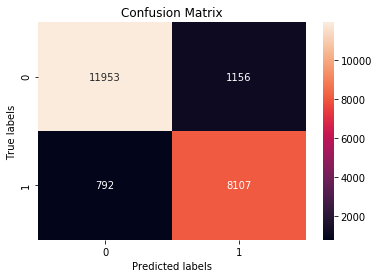

In [31]:
cm = confusion_matrix(all_labels, all_preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d') #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')

In [32]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp= cm[0][1]

acc = (tn + tp) / (tn + fn + tp + fp)
precision = tp / (tp + fp)
recall = tp / (fp + fn)
type_1_err = fp / (fp + fn)
type_2_err = fn / (fp + fn)

print('accuracy = ', acc)
print('precision = ', precision)
print('recall = ', recall)
print('type_1_err : type_2_err = ', type_1_err, ' : ', type_2_err)

accuracy =  0.9114867320974192
precision =  0.8752024182230379
recall =  4.16170431211499
type_1_err : type_2_err =  0.5934291581108829  :  0.406570841889117


* Type II Error被降低了
* Type I Error數量從596上升到1156，上升了560個instances
* Type II Error數量從1072下降到792，下降了280個instances

### ROC Curve and AUC

In [33]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)

roc_auc = auc(fpr, tpr)
print('ROC area = ', roc_auc)

ROC area =  0.9700084541011348


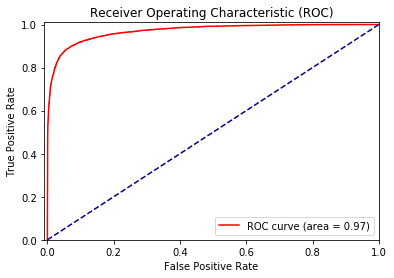

In [34]:
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

### Overview

In [35]:
# ranking
ranking_index = sorted([(abs(label - prob), i) for i, (label, prob) 
                        in enumerate(zip(all_labels, all_probs))])
ranking_actual_false_index = []
ranking_actual_true_index = []
for _, idx in ranking_index:
    if all_labels[idx]:
        ranking_actual_true_index.append(idx)
    else:
        ranking_actual_false_index.append(idx)

In [36]:
def prepare_array(eval_dataloader, idx):
    batch_index = idx // BATCH_SIZE
    index = idx % BATCH_SIZE
    arrays, _ = eval_dataloader[batch_index]
    return arrays[index]


def put_cell(ax, x, y, im, label, pred, prob):
    classes = ['Negative', 'Tumor']
    ax[x, y].imshow(im)
    ax[x, y].set_xticks([])
    ax[x, y].set_yticks([])
    ax[x, y].set_title('{0} / {1} / {2:2f}'.format(classes[label], classes[pred], prob))

Text(0, 0.5, 'random\ntrue positive samples')

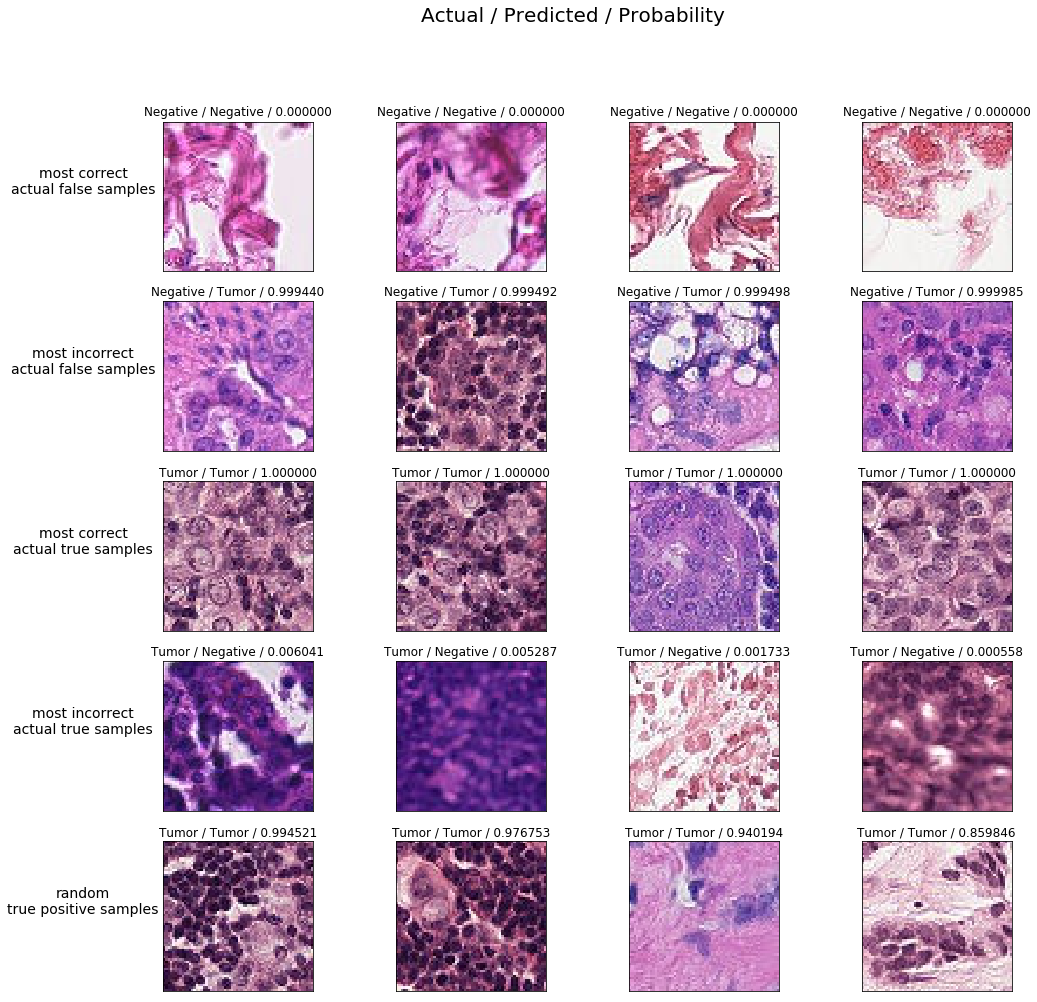

In [37]:
fig, ax = plt.subplots(5, 4, figsize=(16, 16))
fig.suptitle('Actual / Predicted / Probability', fontsize=20)

# top correct on actual false
for i, idx in enumerate(ranking_actual_false_index[:4]):
    array = prepare_array(eval_dataloader, idx)
    img = reverse_img(array).astype('uint8')
    put_cell(ax, 0, i, img, all_labels[idx], all_preds[idx], all_probs[idx])
ax[0, 0].set_ylabel('most correct\nactual false samples', fontsize=14, rotation=0, labelpad=80)

# top incorrect on actual false
for i, idx in enumerate(ranking_actual_false_index[-4:]):
    array = prepare_array(eval_dataloader, idx)
    img = reverse_img(array).astype('uint8')
    put_cell(ax, 1, i, img, all_labels[idx], all_preds[idx], all_probs[idx])
ax[1, 0].set_ylabel('most incorrect\nactual false samples', fontsize=14, rotation=0, labelpad=80)

# top correct on actual true
for i, idx in enumerate(ranking_actual_true_index[:4]):
    array = prepare_array(eval_dataloader, idx)
    img = reverse_img(array).astype('uint8')
    put_cell(ax, 2, i, img, all_labels[idx], all_preds[idx], all_probs[idx])
ax[2, 0].set_ylabel('most correct\nactual true samples', fontsize=14, rotation=0, labelpad=80)

# top incorrect on actual true
for i, idx in enumerate(ranking_actual_true_index[-4:]):
    array = prepare_array(eval_dataloader, idx)
    img = reverse_img(array).astype('uint8')
    put_cell(ax, 3, i, img, all_labels[idx], all_preds[idx], all_probs[idx])
ax[3, 0].set_ylabel('most incorrect\nactual true samples', fontsize=14, rotation=0, labelpad=80)

# random
for i, idx in enumerate([ranking_actual_true_index[j] for j in [4000, 5300, 6200, 7000]]):
    array = prepare_array(eval_dataloader, idx)
    img = reverse_img(array).astype('uint8')
    put_cell(ax, 4, i, img, all_labels[idx], all_preds[idx], all_probs[idx])
ax[4, 0].set_ylabel('random\ntrue positive samples', fontsize=14, rotation=0, labelpad=80)

### Gradient-weighted Class Activation Mapping (Grad-CAM)

千萬別在說CNN是黑盒子了，目前已經有好多種技術可以了解CNN究竟是如何判別的，其中以Grad-CAM最為人所知，它可以告訴我們CNN究竟是看了哪些地方來做出判斷的，並且以heatmap的形式來表示。  

它的運作方法可以簡單這樣說明，首先我們要先了解最後一層Conv Layer的重要性，有兩點！最後一層的Conv Layer所保有的資訊量是最豐富的，而且因為它還沒有被打平，所以仍保有空間的資訊（除非有使用GAP，如果採用GAP的話也可以使用它的始祖CAM），如此一來我們只要把最後一層的Conv Layer的各個channel拆開，再根據輸入資訊所響應的大小當作加權，就可以去疊加出響應的空間位置，而這個加權值則是依據輸入圖片所造成的gradient大小來定義，最後把疊加後的heatmap縮放到和圖片一樣大小並疊合就可以看出CNN用了哪些區域來作判斷。  

而這就好像病理科醫生看著切片去畫記腫瘤的位置，我們就來看看這神奇的方法。

In [38]:
model_aug_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

從上面得知，`'res5c_branch2c'`是最後一層的Conv Layer, 而在上面有2048個channel

In [39]:
LAST_CONV = 'res5c_branch2c'
LAST_CONV_CHANNEL_NUM = 2048

In [40]:
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras import backend as K
import cv2

def get_heatmap_by_grad_cam(model, last_conv_layer_name, last_conv_channel_num, data):
    pred = model.output[:, 0]
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grads = K.gradients(pred, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(data, axis=0)])

    for i in range(last_conv_channel_num):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (data.shape[1], data.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    return heatmap

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'random\ntrue positive samples')

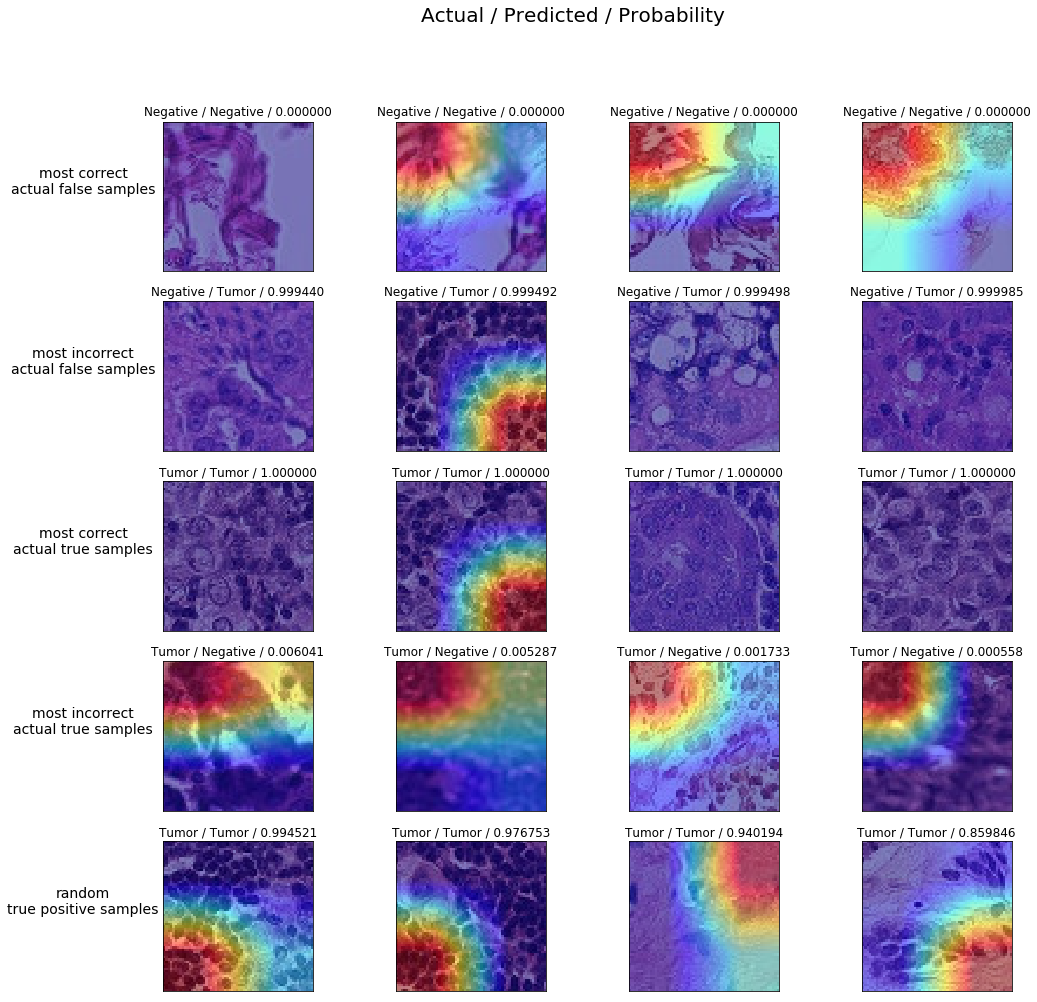

In [41]:
fig, ax = plt.subplots(5, 4, figsize=(16, 16))
fig.suptitle('Actual / Predicted / Probability', fontsize=20)

# top correct on actual false
for i, idx in enumerate(ranking_actual_false_index[:4]):
    array = prepare_array(eval_dataloader, idx)
    heatmap = get_heatmap_by_grad_cam(model_aug_2, LAST_CONV, LAST_CONV_CHANNEL_NUM, array)
    original_img = reverse_img(array).astype('uint8')
    put_cell(ax, 0, i, original_img, all_labels[idx], all_preds[idx], all_probs[idx])
    ax[0, i].imshow(heatmap, alpha=0.5, cmap='jet')
ax[0, 0].set_ylabel('most correct\nactual false samples', fontsize=14, rotation=0, labelpad=80)

# top incorrect on actual false
for i, idx in enumerate(ranking_actual_false_index[-4:]):
    array = prepare_array(eval_dataloader, idx)
    heatmap = get_heatmap_by_grad_cam(model_aug_2, LAST_CONV, LAST_CONV_CHANNEL_NUM, array)
    original_img = reverse_img(array).astype('uint8')
    put_cell(ax, 1, i, original_img, all_labels[idx], all_preds[idx], all_probs[idx])
    ax[1, i].imshow(heatmap, alpha=0.5, cmap='jet')
ax[1, 0].set_ylabel('most incorrect\nactual false samples', fontsize=14, rotation=0, labelpad=80)

# top correct on actual true
for i, idx in enumerate(ranking_actual_true_index[:4]):
    array = prepare_array(eval_dataloader, idx)
    heatmap = get_heatmap_by_grad_cam(model_aug_2, LAST_CONV, LAST_CONV_CHANNEL_NUM, array)
    original_img = reverse_img(array).astype('uint8')
    put_cell(ax, 2, i, original_img, all_labels[idx], all_preds[idx], all_probs[idx])
    ax[2, i].imshow(heatmap, alpha=0.5, cmap='jet')
ax[2, 0].set_ylabel('most correct\nactual true samples', fontsize=14, rotation=0, labelpad=80)

# top incorrect on actual true
for i, idx in enumerate(ranking_actual_true_index[-4:]):
    array = prepare_array(eval_dataloader, idx)
    heatmap = get_heatmap_by_grad_cam(model_aug_2, LAST_CONV, LAST_CONV_CHANNEL_NUM, array)
    original_img = reverse_img(array).astype('uint8')
    put_cell(ax, 3, i, original_img, all_labels[idx], all_preds[idx], all_probs[idx])
    ax[3, i].imshow(heatmap, alpha=0.5, cmap='jet')
ax[3, 0].set_ylabel('most incorrect\nactual true samples', fontsize=14, rotation=0, labelpad=80)

# random
for i, idx in enumerate([ranking_actual_true_index[j] for j in [4000, 5300, 6200, 7000]]):
    array = prepare_array(eval_dataloader, idx)
    heatmap = get_heatmap_by_grad_cam(model_aug_2, LAST_CONV, LAST_CONV_CHANNEL_NUM, array)
    original_img = reverse_img(array).astype('uint8')
    put_cell(ax, 4, i, original_img, all_labels[idx], all_preds[idx], all_probs[idx])
    ax[4, i].imshow(heatmap, alpha=0.5, cmap='jet')
ax[4, 0].set_ylabel('random\ntrue positive samples', fontsize=14, rotation=0, labelpad=80)

很神奇的! AI就像是病理科醫生一樣可以標記出腫瘤的位置。

## Reference
* https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
* https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
* https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb